In [36]:
from datasets import BarcelonaDataModule, BarcelonaDataset

from __future__ import print_function
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import lightning as L

from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.transforms as transforms
import torchvision.models as models


In [37]:
data = BarcelonaDataModule(root = './data', num_workers=0)

data.setup()
data_train = data.train_dataloader()


data_test = data.test_dataloader()
data_val = data.val_dataloader()

alexnet = models.AlexNet()
from torchvision.models import alexnet, AlexNet_Weights


In [38]:
class GlobuleClassifierAlex(pl.LightningModule):
    def __init__(self, num_classes=8):
        super().__init__()
        self.test_preds = []
        self.test_targets=[]
        self.save_hyperparameters()
        self.num_classes = num_classes


        # Charger AlexNet pré-entraîné
        weights = AlexNet_Weights.DEFAULT
        self.model = alexnet(weights=weights)

        # Geler les couches convolutionnelles
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Remplacer la dernière couche fully connected pour 8 classes
        self.model.classifier[1] = nn.Linear(9216, 271)
        self.model.classifier[4] = nn.Linear(271,271)
        """in_features = self.model.classifier[6].in_features"""
        self.model.classifier[6] = nn.Linear(271, num_classes)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)

        self.test_preds.append(preds.cpu())
        self.test_targets.append(y.cpu())

        return {"loss": F.cross_entropy(logits, y)}

    def on_test_epoch_end(self):
        preds = torch.cat(self.test_preds)
        targets = torch.cat(self.test_targets)

        # Calcul accuracy
        acc = accuracy_score(targets, preds)
        self.log("test_accuracy", acc)

        # Matrice de confusion
        cm = confusion_matrix(targets, preds, labels=range(self.num_classes))
        self.conf_matrix = cm
        self.test_acc = acc  # stocker l'accuracy aussi

model = GlobuleClassifierAlex(num_classes=8)

trainer = pl.Trainer(
        max_epochs=5,
        accelerator="gpu",
        devices=1,  # ou "auto" si tu veux laisser Lightning choisir
        num_sanity_val_steps=0,
        enable_checkpointing=False,
        log_every_n_steps=1,
    )

print(trainer)
    

trainer.fit(model, train_dataloaders=data_train, val_dataloaders=data_val)

        
        
        
        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | AlexNet          | 5.0 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.6 M     Trainable params
2.5 M     Non-trainable params
5.0 M     Total params
20.174    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9254437685012817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


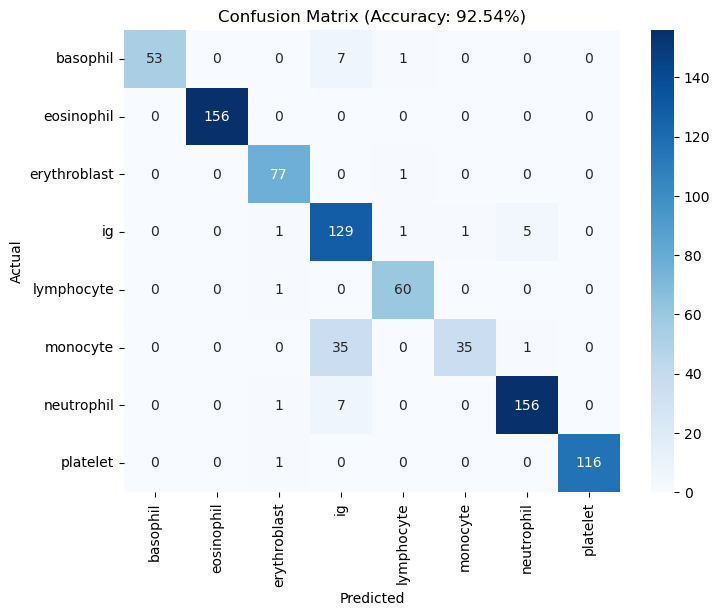

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lancer le test
trainer.test(model, data_test)


# Récupérer et afficher
conf_matrix = model.conf_matrix
acc = model.test_acc

labels = data_train.dataset.class_to_idx.keys()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Accuracy: {acc:.2%})")
plt.show()

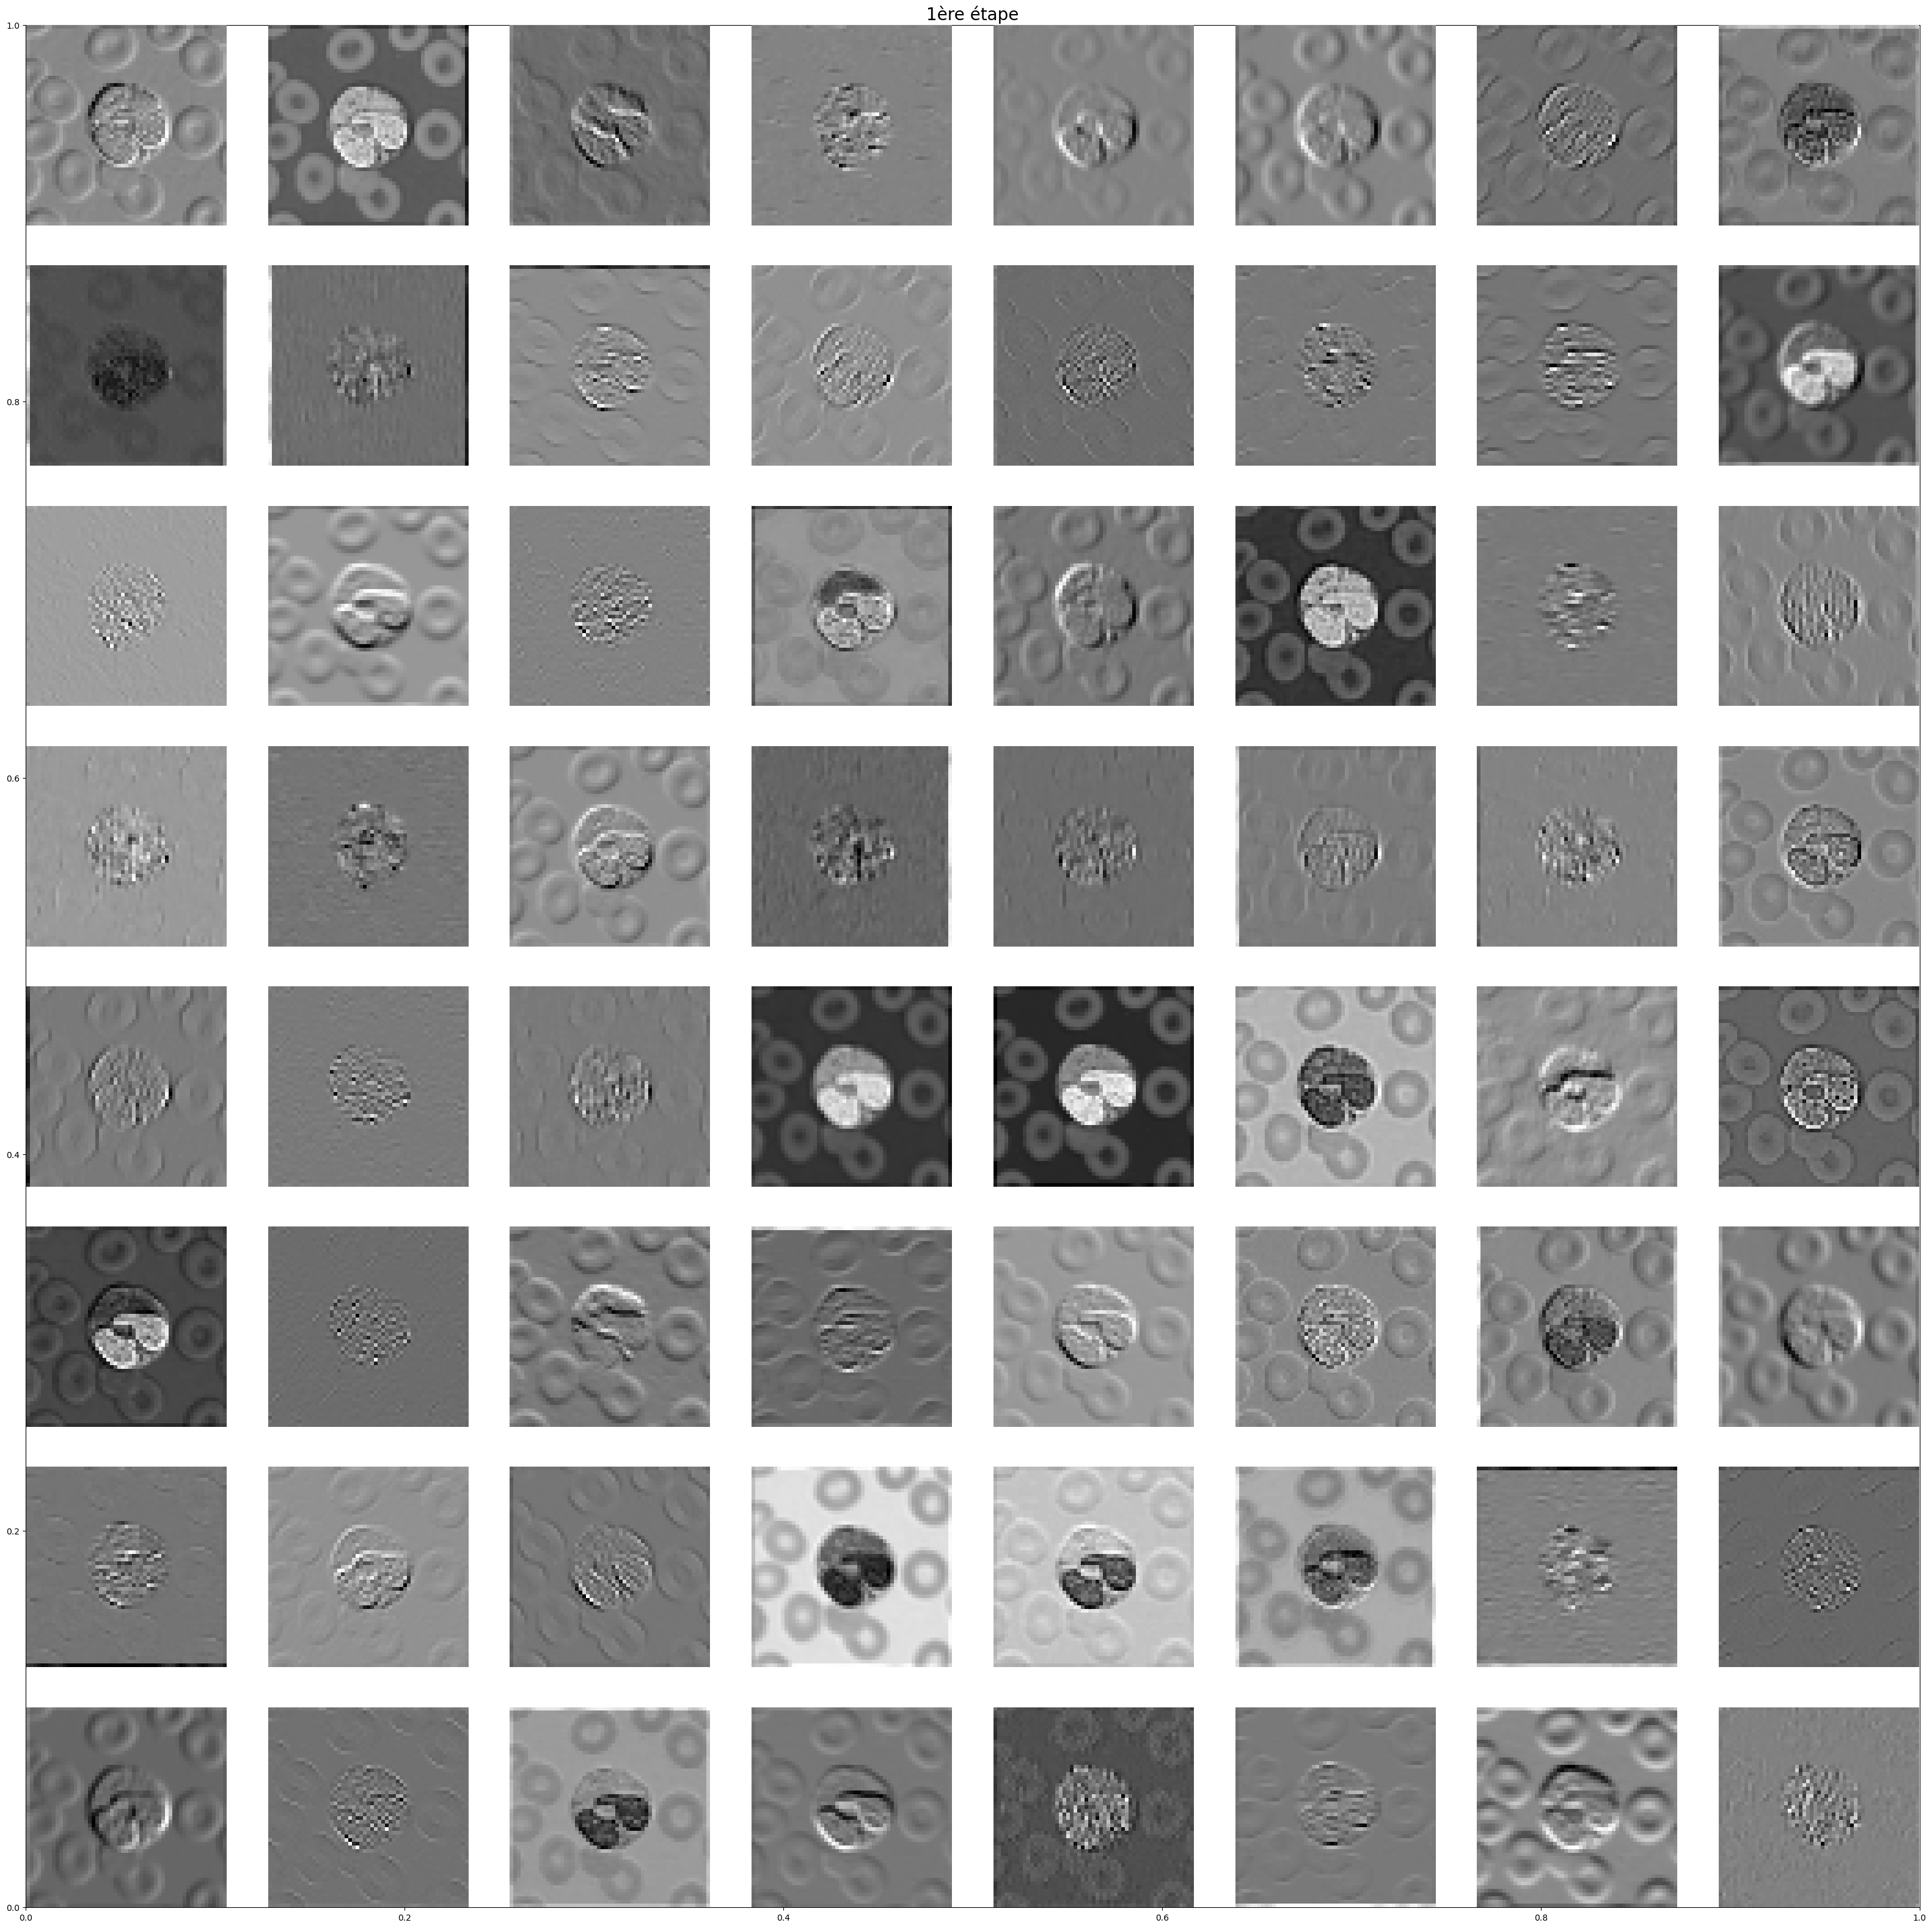

In [69]:
img_path = './data/barcelona/test/eosinophil/eo_2590.jpg'
img = Image.open(img_path).convert('RGB')  # convert to RGB if needed
import math

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # adapter selon le modèle
    transforms.ToTensor(),          # convert to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet
                         std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img).unsqueeze(0)  # shape: (1, 3, H, W)

first_noyau = model.model.features[0]
second_noyau = model.model.features[:4]

with torch.no_grad():
    premier_noyau = first_noyau(img_tensor)
    deuxieme_noyau = second_noyau(img_tensor)
    


n_maps_1 = premier_noyau[0].shape[0]
cols = 8  # nombre de colonnes d’affichage
rows_1 = math.ceil(n_maps_1 / cols)

plt.figure(figsize=(cols * 5, rows * 5))
plt.title("1ère étape", fontsize = 20)
for i in range(n_maps_1):
    plt.subplot(rows_1, cols, i + 1)
    plt.imshow(premier_noyau[0][i].cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    

plt.show()

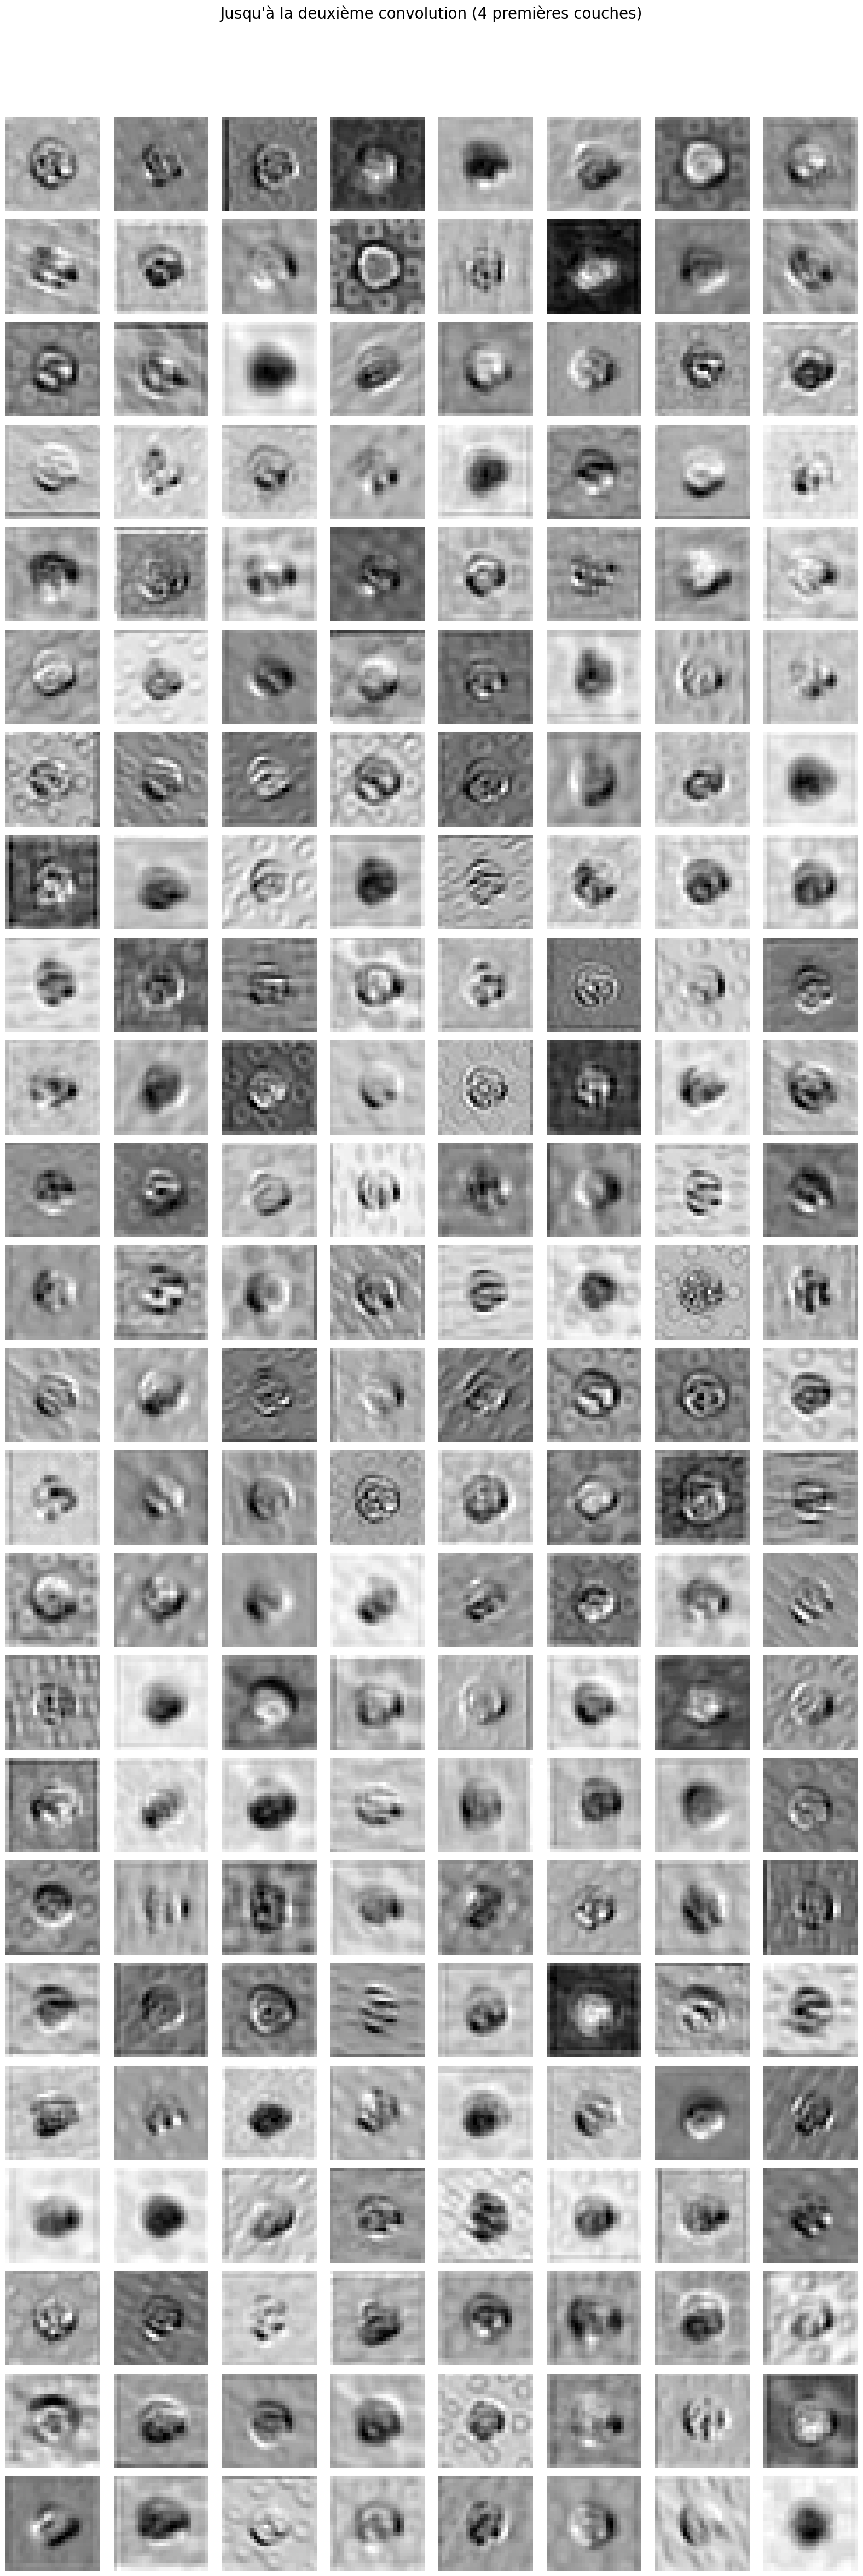

In [71]:
plt.figure(figsize=(cols * 2, rows_2 * 2))
plt.suptitle("Jusqu'à la deuxième convolution (4 premières couches)", fontsize=20)

n_maps_2 = deuxieme_noyau.shape[1]
rows_2 = math.ceil(n_maps_2 / cols)
for i in range(n_maps_2):
    plt.subplot(rows_2, cols, i + 1)
    plt.imshow(deuxieme_noyau[0][i].cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # laisse la place pour le titre en haut
plt.show()